## Analogues #1

In [2]:
# load libraries
import pandas as pd
import numpy as np
import netCDF4
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy as ccrs

import scipy.stats as stats
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [154]:
#import data
global_months = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_monthly_temperature_1940-2024_global.nc")
era_max = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_max.nc")
era_mean = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_mean.nc")

era_max_regrid = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_max_regrid.nc")
mask = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/europe_mask_0.5.nc")
europe_mask = (mask/mask).sel(time = mask.time[0]).t2m

In [95]:
#find gwd
#weighting by latitude
weights = np.cos(np.deg2rad(global_months.latitude))
weighted_weights = weights/np.mean(weights)
#global temperatures
weighted_temps = global_months.sel(expver = 1).groupby("latitude")*weighted_weights
weighted_global_mean = weighted_temps.t2m.sel(time = slice('1950', '2022')).mean(dim = ['latitude', 'longitude'])
weighted_yearly_mean = weighted_global_mean.groupby("time.year").mean()
weighted_rolling_mean = weighted_yearly_mean.rolling(year = 5, center=True, min_periods = 3).mean()
weighted_gwd_2022 = weighted_rolling_mean[-1]
weighted_gwd = weighted_rolling_mean - weighted_gwd_2022
#gwd.plot()
weighted_gwd

<xarray.DataArray 't2m' (year: 73)>
array([-1.0198059 , -0.99212646, -1.0148926 , -1.019104  , -1.061676  ,
       -1.0514526 , -1.0432739 , -1.0027466 , -0.9676819 , -0.9055786 ,
       -0.9052429 , -0.91085815, -0.95184326, -0.971405  , -0.9904785 ,
       -0.9948425 , -1.0190125 , -0.97457886, -0.9476013 , -0.9671936 ,
       -0.9623718 , -0.92440796, -0.967865  , -1.0013123 , -1.0174866 ,
       -1.0035706 , -1.0221252 , -0.95440674, -0.86538696, -0.7559509 ,
       -0.7435913 , -0.68045044, -0.69091797, -0.7357483 , -0.76950073,
       -0.7322693 , -0.7276306 , -0.70410156, -0.6262207 , -0.5770569 ,
       -0.6053772 , -0.6309509 , -0.62561035, -0.63098145, -0.6514282 ,
       -0.60098267, -0.5220032 , -0.50405884, -0.52267456, -0.48324585,
       -0.4489746 , -0.4550171 , -0.41952515, -0.35061646, -0.32333374,
       -0.3168335 , -0.33422852, -0.31323242, -0.3055725 , -0.3166504 ,
       -0.31600952, -0.28344727, -0.26919556, -0.24420166, -0.15411377,
       -0.09335327, -0.05395508,  0.00463867,  0.03994751,  0.00683594,
       -0.00170898,  0.01583862,  0.        ], dtype=float32)
Coordinates:
    expver   int32 1
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022

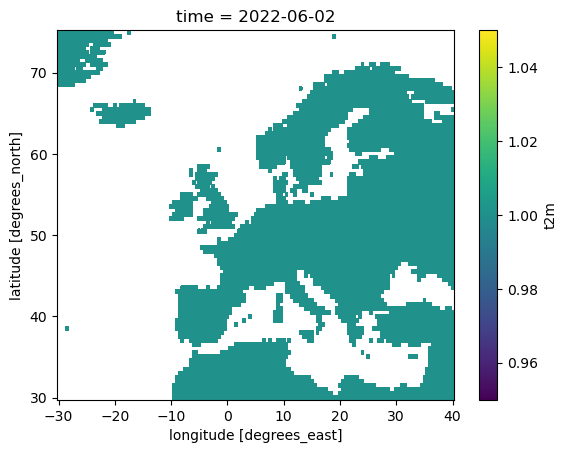

In [155]:
europe_mask.plot()

In [181]:
#weight era_max by latitude
lats = era_max.sel(latitude = slice(55,45)).latitude
max_weights = np.cos(np.deg2rad(lats))
weighted_max_weights = max_weights/np.mean(max_weights)
era_max_west = (era_max.t2m - 273.15).sel(latitude = slice(55,45), longitude = slice(-5,15))
era_max_temp_weighted = era_max_west.groupby("latitude")*weighted_max_weights

#Find TXx and TXm
TXx_masked = era_max_temp_weighted.groupby("time.year").max()*europe_mask.drop_vars("time")
#TXm_masked = era_max.groupby("time.year").mean()*europe_mask

#TXx = era_max_temp_weighted.groupby("time.year").max()
#TXm = era_max_temp_weighted.groupby("time.year").mean()


west_europe_ts = TXx_masked.mean(dim = ["latitude", "longitude"], skipna = True)
#west_europe_TXm = TXm.mean(dim = ["latitude", "longitude"]).t2m
time = TXx.year

TXx_trend_gwd = stats.linregress(weighted_gwd,(west_europe_ts))
TXx_trend_time = stats.linregress(time,(west_europe_ts))

TXx_trend_gwd

KeyboardInterrupt: 

In [180]:
west_europe_ts

<xarray.Dataset>
Dimensions:  (year: 73)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022
Data variables:
    t2m      (year) float32 306.7 304.5 308.3 305.6 ... 312.0 309.7 307.2 309.2

Text(0.5, 1.0, 'Summer Maximal Temperatures over Western Europe Land \n [5W-15E, 45N-55N] on 0.25x0.25 grid')

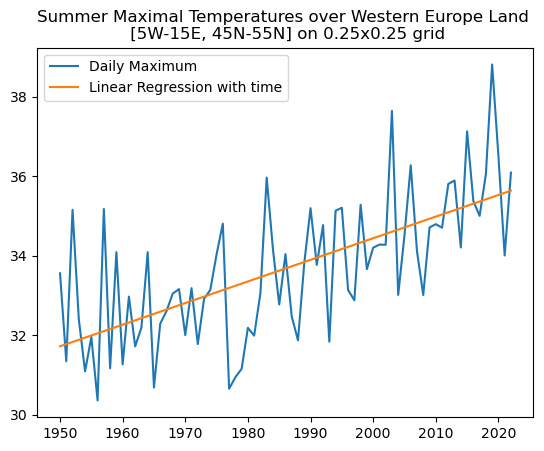

In [179]:
f, axs = plt.subplots(1,1)
plt.plot(time,(west_europe_ts.t2m - 273.15).values, label = "Daily Maximum")
#((west_europe_TXx-273.15)).plot(label = "Daily Maximum")
trend_line = time*(TXx_trend_time.slope) + TXx_trend_time.intercept
plt.plot(time, trend_line - 273.15, label = "Linear Regression with time")
#((west_europe_TXm-273.15)).plot(label = "Daily Mean")
plt.legend()
plt.title("Summer Maximal Temperatures over Western Europe Land \n [5W-15E, 45N-55N] on 0.25x0.25 grid")
#(gwd).plot(label = "Global Average")

In [ ]:
TXx

In [53]:
lons,lats = np.linspace(1,len(TXx.longitude),len(TXx.longitude)), np.linspace(1,len(TXx.latitude),len(TXx.latitude))
max_trend_map = (np.meshgrid(lons,lats)[1]).T
for ii, lon in enumerate(TXx.longitude):
    for jj, lat in enumerate(TXx.latitude):
        temps = TXx.sel(longitude = lon, latitude = lat).t2m
        regression = stats.linregress(weighted_gwd, temps)
        trend = regression.slope
        max_trend_map[ii,jj] = trend

AttributeError: 'DataArray' object has no attribute 't2m'

In [ ]:
mean_trend_map = (np.meshgrid(lons,lats)[1]).T
for ii, lon in enumerate(TXm.longitude):
    for jj, lat in enumerate(TXm.latitude):
        temps = TXm.sel(longitude = lon, latitude = lat).t2m
        regression = stats.linregress(weighted_gwd, temps)
        trend = regression.slope
        mean_trend_map[ii,jj] = trend

In [ ]:
transform = ccrs.Orthographic(central_longitude = 5, central_latitude = 50)
fig = plt.figure(figsize = (10,15))
latgrids=[40,50,60]
longrids=[-20,-10,0,10,20,30]

ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(TXx.longitude, TXx.latitude, max_trend_map.T,
                                    cmap = 'afmhot_r', levels = np.linspace(0,6,13), 
                                 transform = ccrs.PlateCarree())
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 70])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("TXx Trend (1950-2022)")

In [ ]:
fig = plt.figure(figsize = (10,15))
ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(TXm.longitude, TXm.latitude, mean_trend_map.T,
                                    cmap = 'afmhot_r', levels = np.linspace(0,6,13), 
                                 transform = ccrs.PlateCarree())
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 70])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("TXm trend (1950-2022)")